In [31]:
import random
import torch
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn import preprocessing
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [32]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

In [33]:
SEED = 1038893

fix_random(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

root = "../../data/ml-25m"

Device: cpu


## Data Acquisition

In [34]:
def get_data_from_csv(file: str, nrows=None):
    if nrows:
        df = pd.read_csv(f"{root}/{file}", nrows=nrows)
    else:
        df = pd.read_csv(f"{root}/{file}")
    print(f"Loaded ml-25m data: {root}/{file}")

    return df

def get_movies_from_csv(nrows=None):
    path = "movies.csv"

    data = get_data_from_csv(path, nrows)
    # data = get_data_from_csv(path)
    print(data.head())
    return data

def get_ratings_from_csv(nrows=None):
    path = "ratings.csv"

    data = get_data_from_csv(path, nrows)
    # data = get_data_from_csv(path)

    data.drop("timestamp", axis=1, inplace=True)
    # todo: drop user id
    #data.drop("userId", axis=1, inplace=True)

    return data

def get_tag_relevances_from_csv(nrows=None):
    path = "genome-scores.csv"

    return get_data_from_csv(path, nrows)

In [35]:
genome_scores_path = "genome-scores.csv"
ratings_path = "ratings.csv"

In [36]:
ratings = get_ratings_from_csv()
movies = get_movies_from_csv()
print(ratings)

Loaded ml-25m data: ../../data/ml-25m/ratings.csv
Loaded ml-25m data: ../../data/ml-25m/movies.csv
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
          userId  movieId  rating
0              1      296     5.0
1              1      306     3.5
2              1      307     5.0
3              1      665     5.0
4              1      899     3.5
...          ...      ...     ...
25000090  162541    50872     4.5
25000091  162541    55768     2.5


In [37]:
genome_scores = get_tag_relevances_from_csv()
print(genome_scores)

Loaded ml-25m data: ../../data/ml-25m/genome-scores.csv
          movieId  tagId  relevance
0               1      1    0.02875
1               1      2    0.02375
2               1      3    0.06250
3               1      4    0.07575
4               1      5    0.14075
...           ...    ...        ...
15584443   206499   1124    0.11000
15584444   206499   1125    0.04850
15584445   206499   1126    0.01325
15584446   206499   1127    0.14025
15584447   206499   1128    0.03350

[15584448 rows x 3 columns]


In [41]:
class LinearRegressionModel:
    def __init__(self, ratings,movies,relevance, seed=1038893):
        import matplotlib.pyplot as plt
        relevance_matrix = relevance.pivot_table(index='movieId', columns='tagId', values='relevance', fill_value=0)
        
        
        # Merge the ratings and relevance data
        mean_ratings = ratings.groupby('movieId', as_index=False)['rating'].mean()
        X = mean_ratings.merge(relevance_matrix, on='movieId')
        X.columns = X.columns.astype(str)
        
        ratings = None  

        # mescolare le righe del DataFrame
        X = X.sample(frac=1,random_state=seed).reset_index(drop=True)
        
        y = X['rating']
        X.drop("movieId", axis=1, inplace=True)
        X = X.drop('rating', axis=1)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
        print(self.X_train.shape, self.X_test.shape, self.y_train.shape, self.y_test.shape)

        pca = PCA(n_components=0.95)
        pca.fit(self.X_train)
        self.X_train_t = pca.transform(self.X_train)
        self.X_test_t = pca.transform(self.X_test)
        #print(self.X_train)
        #print(self.X_train_t)
        plt.scatter(self.X_train_t[:, 0], self.X_train_t[:, 1], c=self.y_train, cmap='viridis')
        plt.show()
        
        plt.scatter(self.X_test_t[:, 0], self.X_test_t[:, 1], c=self.y_test, cmap='viridis')
        plt.show()
       
        self.model = LassoCV(n_jobs=-1, cv=3, verbose=2, random_state=seed)

    def evaluate(self):
        # Fit the model to the training data
        #self.tuning(self.X_train, self.y_train)
        self.model.fit(self.X_train, self.y_train)
        print("Modello fittato senza PCA transformation")
        print(self.model.alpha_)
        self.test(self.X_test)

        self.model = LassoCV(n_jobs=-1, cv=3, verbose=1, random_state=SEED)
        #self.tuning(self.X_train_t, self.y_train)
        self.model.fit(self.X_train_t, self.y_train)
        print("Modello fittato con PCA transformation")
        print(self.model.alpha_)
        self.test(self.X_test_t)
    

    def test(self, X_test):
        # Predict ratings for the test data
        y_pred = self.model.predict(X_test)

        # Compute the mean squared error
        mse = mean_squared_error(self.y_test, y_pred)
        rmse = mean_squared_error(self.y_test, y_pred, squared=False)
        r2 = r2_score(self.y_test, y_pred)
        mae = mean_absolute_error(self.y_test, y_pred)

        print(f"MSE: {mse} RMSE: {rmse} R2: {r2} MAE: {mae}")
        score = self.model.score(X_test, self.y_test)
        print(f"Score:{score}")
        print("Intercept: "+str( self.model.intercept_))
        print("Coefficients: "+ str(self.model.coef_))


(11052, 1128) (2764, 1128) (11052,) (2764,)


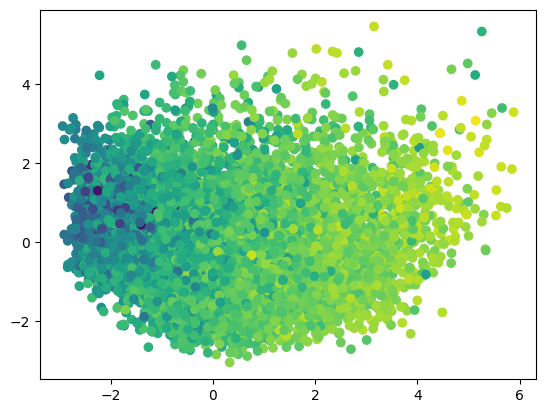

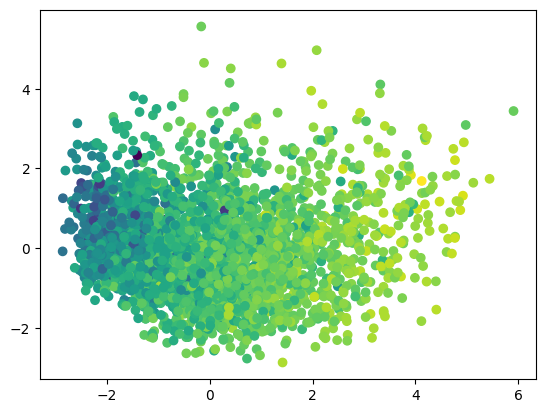

In [42]:
lr = LinearRegressionModel(ratings,movies,genome_scores, SEED)

In [43]:
lr.evaluate()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Path: 000 out of 100
Path: 001 out of 100
Path: 000 out of 100
Path: 002 out of 100
Path: 001 out of 100
Path: 003 out of 100
Path: 000 out of 100
Path: 002 out of 100
Path: 004 out of 100
Path: 001 out of 100
Path: 003 out of 100
Path: 005 out of 100
Path: 002 out of 100
Path: 004 out of 100
Path: 006 out of 100
Path: 003 out of 100
Path: 005 out of 100
Path: 007 out of 100
Path: 004 out of 100
Path: 006 out of 100
Path: 008 out of 100
Path: 005 out of 100
Path: 007 out of 100
Path: 009 out of 100
Path: 006 out of 100
Path: 008 out of 100
Path: 007 out of 100
Path: 010 out of 100
Path: 009 out of 100
Path: 008 out of 100
Path: 011 out of 100
Path: 010 out of 100
Path: 009 out of 100
Path: 012 out of 100
Path: 011 out of 100
Path: 010 out of 100
Path: 013 out of 100
Path: 011 out of 100
Path: 012 out of 100
Path: 014 out of 100
Path: 012 out of 100
Path: 013 out of 100
Path: 015 out of 100
Path: 014 out of 100
Path: 013 out of 100
Path: 016 out of 100
Path: 015 out of 100
Path: 014 out

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.0s finished
C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.586e+01, tolerance: 2.574e-01
  model = cd_fast.enet_coordinate_descent(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Modello fittato senza PCA transformation
7.425262873115622e-05
MSE: 0.005486814781830245 RMSE: 0.07407303680712872 R2: 0.9771154908004298 MAE: 0.0568421300459931
Score:0.9771154908004298
Intercept: 3.5271251312027654
Coefficients: [-0.         -0.01475411 -0.         ...  0.         -0.08960382
  0.02876333]


............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished


Modello fittato con PCA transformation
0.0005675190692206821
MSE: 0.009433868123483865 RMSE: 0.09712810161577269 R2: 0.9606530472699164 MAE: 0.07491622588172611
Score:0.9606530472699164
Intercept: 3.273582484249796
Coefficients: [ 0.2188263  -0.04000356  0.13220201  0.02207592 -0.06062837  0.11535508
  0.01497897  0.0198561  -0.04716478 -0.06366332  0.02112378 -0.13557308
 -0.0791432   0.08944358  0.21766084  0.09731388  0.0701149  -0.14484514
  0.09903571 -0.27839565  0.13200035  0.08317908  0.08925387  0.04045637
  0.19813102 -0.15619669  0.00471035  0.12386163  0.07090311  0.06324574
  0.01176952 -0.14488482  0.09537055  0.12009249 -0.08971553 -0.03530571
  0.06505104  0.02388831  0.13483341 -0.14536908  0.0566928   0.09782204
 -0.0791478   0.03749662 -0.00456633  0.0357042  -0.10148919 -0.04302175
 -0.05659392  0.01895395 -0.03762437  0.03831726  0.          0.15014906
  0.1133212  -0.00120069  0.09427556  0.         -0.00357856  0.12561378
 -0.01387554 -0.01658164 -0.00800277 -0. 

In [44]:
#lr.test()